<a href="https://colab.research.google.com/github/nasaharvest/street2sat/blob/Duplicate-Resolution-Notebook/BaselineDuplicateResolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Duplicate Point Resolution**

**Author:** Anjali Paliyam

**Last modified:** June 22, 2024

**Description:** Generates a new file with no duplicate points at any location. Specifically, the notebook:

1. Load DataFrame with all the points
2. For each gruop, find max dominant crop and cut remaining duplicate points
3. Testing to see if function works
4. Download new csv file with no duplicates

# **1. Load DataFrame with all the points**

In [ ]:
import pandas as pd
import numpy as np

# import dataframe
df = pd.read_csv("/content/Kenya_ADM1_51331_Rift_Valley_ADM2_51391_Trans_Nzoia.csv")
# print number of rows
print(len(df))
# display first 10 points
df.head(10)

2714


,road_pixel_centroid,is_right_hand_drive,driving_easting,driving_northing,offset_field_coord,offset_field_pixel_centroid,time_computed,level_0,index,pixel_height,...,wheat,soybean,banana,maize,sugarcane,rice,tobacco,dominant_crop,ADM1 Label,ADM2 Label
0,"(1.1306463492078673, 35.09892329424909)",False,5.158571,9.792292,"(1.1307092060770998, 35.09873271814292)","(1.1307368916494316, 35.09874371090061)",2024-05-28 14:14:26.907873,21217,47156,2028.0,...,0.0003,0.055,0.0,0.0000,0.0133,0.0009,0.0006,soybean,51331 Rift Valley,51391 Trans Nzoia
1,"(1.1804573597359764, 35.10659504241084)",False,0.080946,10.706703,"(1.180453816321564, 35.10640005556899)","(1.180457496751208, 35.10641539186584)",2024-05-28 14:14:29.964124,21406,47520,2028.0,...,0.0004,0.000,0.0,0.0633,0.0002,0.0001,0.0006,maize,51331 Rift Valley,51391 Trans Nzoia
2,"(1.1804573597359764, 35.10659504241084)",False,-0.171095,5.419550,"(1.1804957435011878, 35.10639863459324)","(1.180457496751208, 35.10641539186584)",2024-05-28 14:14:30.002952,21407,47521,2028.0,...,0.0000,0.000,0.0,0.0617,0.0000,0.0001,0.0001,maize,51331 Rift Valley,51391 Trans Nzoia
3,"(1.1805477709312058, 35.106595110483106)",False,-0.453528,10.850082,"(1.180542997491937, 35.10639620047886)","(1.1805479079569345, 35.10641545993231)",2024-05-28 14:14:30.039680,21408,47522,2028.0,...,0.0000,0.000,0.0,0.0507,0.0000,0.0000,0.0001,maize,51331 Rift Valley,51391 Trans Nzoia
4,"(1.1806381821263723, 35.10659517856059)",False,-0.360374,5.441531,"(1.1805877999313301, 35.10639323307852)","(1.1805479079569345, 35.10641545993231)",2024-05-28 14:14:30.076760,21409,47523,2028.0,...,0.0048,0.000,0.0,0.0450,0.0007,0.0001,0.0008,maize,51331 Rift Valley,51391 Trans Nzoia
5,"(1.0724274066004387, 35.08990027171913)",False,3.403538,-11.666453,"(1.0724862352309026, 35.090077591084516)","(1.072517695322181, 35.0900799789151)",2024-05-28 14:14:30.789400,21433,47650,2028.0,...,0.0000,0.000,0.0,0.0525,0.0000,0.0001,0.0001,maize,51331 Rift Valley,51391 Trans Nzoia
6,"(1.0723369943662262, 35.089900210372846)",False,3.258363,-11.013980,"(1.072387290461947, 35.0901066003232)","(1.072427283098441, 35.09007991755836)",2024-05-28 14:14:30.826186,21434,47652,2028.0,...,0.0000,0.000,0.0,0.0539,0.0000,0.0000,0.0001,maize,51331 Rift Valley,51391 Trans Nzoia
7,"(1.0652828757914967, 35.09276976561736)",False,2.563819,-4.732139,"(1.0653289422481709, 35.09292381054659)","(1.0653731650053633, 35.0929494717422)",2024-05-28 14:14:32.403173,21502,47746,2028.0,...,0.0011,0.000,0.0,0.0682,0.0000,0.0000,0.0001,maize,51331 Rift Valley,51391 Trans Nzoia
8,"(1.06519246371953, 35.09276970459626)",False,5.161027,-9.453196,"(1.065286753289972, 35.09294683483263)","(1.0652827529438822, 35.09294941071066)",2024-05-28 14:14:32.439858,21503,47747,2028.0,...,0.0000,0.000,0.0,0.0808,0.0000,0.0000,0.0001,maize,51331 Rift Valley,51391 Trans Nzoia
9,"(1.0651924023022525, 35.09285952714288)",False,2.898152,-5.229637,"(1.0652404537927502, 35.092972288971154)","(1.0652827529438822, 35.09294941071066)",2024-05-28 14:14:32.477935,21504,47748,2028.0,...,0.0000,0.000,0.0,0.0948,0.0000,0.0000,0.0001,maize,51331 Rift Valley,51391 Trans Nzoia


# **2. For each group, find max dominant crop and cut remaining duplicate points**


In [ ]:
# takes in a group and returns only one point with max dominant crop
def get_max_dominant_crop(group):
  max_idx = group.apply(lambda x: x[x['dominant_crop']], axis=1).idxmax()
  return group.loc[max_idx]

# create new DataFrame with no duplicate - using groupby and applying get_max_dominant_crop on each group
result_df = df.groupby('road_pixel_centroid').apply(get_max_dominant_crop).reset_index(drop=True)

In [ ]:
# display first 10 points of resulting DataFrame
result_df.head(10)

,road_pixel_centroid,is_right_hand_drive,driving_easting,driving_northing,offset_field_coord,offset_field_pixel_centroid,time_computed,level_0,index,pixel_height,...,wheat,soybean,banana,maize,sugarcane,rice,tobacco,dominant_crop,ADM1 Label,ADM2 Label
0,"(0.8732291514527724, 34.95989598932899)",False,-8.940332,1.377780,"(0.8730573928690418, 34.959837344837574)","(0.8730483593082711, 34.95980607073753)",2024-05-28 14:20:24.602552,35884,70597,2028.0,...,0.0007,0.0,0.0,0.0328,0.0000,0.0291,0.0003,maize,51331 Rift Valley,51391 Trans Nzoia
1,"(0.8732292457556264, 34.95971633949565)",False,-8.695701,1.941948,"(0.8730896367048406, 34.959676253187986)","(0.873048406448853, 34.95971624582271)",2024-05-28 14:20:24.677047,35888,70601,2028.0,...,0.0001,0.0,0.0,0.0530,0.0126,0.0002,0.0004,maize,51331 Rift Valley,51391 Trans Nzoia
2,"(0.8797948068442457, 34.85210586479859)",False,-3.165075,7.197741,"(0.8796947894773058, 34.85195640098838)","(0.8797044712842732, 34.851926158733114)",2024-05-28 14:20:24.823296,35892,70606,2028.0,...,0.0143,0.0,0.0,0.0860,0.0033,0.0001,0.0016,maize,51331 Rift Valley,51391 Trans Nzoia
3,"(0.88042791899706, 34.85183668487617)",False,-1.749519,3.604314,"(0.8803733139773744, 34.851648333771884)","(0.8803375834751246, 34.85165697872731)",2024-05-28 14:20:25.085345,35899,70627,2028.0,...,0.0000,0.0,0.0,0.1440,0.0000,0.0000,0.0001,maize,51331 Rift Valley,51391 Trans Nzoia
4,"(0.8805183443501314, 34.851836729507085)",False,-3.499046,7.219688,"(0.880406111788292, 34.851632586699424)","(0.880428008837471, 34.851657023349325)",2024-05-28 14:20:25.122031,35900,70628,2028.0,...,0.0000,0.0,0.0,0.1548,0.0000,0.0000,0.0001,maize,51331 Rift Valley,51391 Trans Nzoia
5,"(0.8805183892760393, 34.85174689874379)",False,-3.309865,7.341432,"(0.8804770566401203, 34.85160077805628)","(0.8805184791213271, 34.85156723720346)",2024-05-28 14:20:25.195992,35902,70630,2028.0,...,0.0002,0.0,0.0,0.1717,0.0000,0.0001,0.0001,maize,51331 Rift Valley,51391 Trans Nzoia
6,"(0.8806088146336789, 34.85174694337713)",False,-1.449023,3.737167,"(0.8805198100514715, 34.85158405699925)","(0.8805184791213271, 34.85156723720346)",2024-05-28 14:20:25.232187,35903,70631,2028.0,...,0.0000,0.0,0.0,0.1705,0.0000,0.0001,0.0001,maize,51331 Rift Valley,51391 Trans Nzoia
7,"(0.880699239991272, 34.851746988015066)",False,-2.586612,8.005315,"(0.8806362866455192, 34.85154541364846)","(0.8806089044881951, 34.85156728183247)",2024-05-28 14:20:25.343552,35906,70634,2028.0,...,0.0000,0.0,0.0,0.1428,0.0000,0.0000,0.0001,maize,51331 Rift Valley,51391 Trans Nzoia
8,"(0.8808801356485086, 34.85165724652816)",False,-0.781433,4.401035,"(0.8808363773691428, 34.851494989578114)","(0.8808802255263564, 34.85147758496134)",2024-05-28 14:20:25.379706,35907,70639,2028.0,...,0.0000,0.0,0.0,0.1551,0.0000,0.0003,0.0001,maize,51331 Rift Valley,51391 Trans Nzoia
9,"(0.880970561010577, 34.85165729117767)",False,-0.324813,3.992081,"(0.8809255288380352, 34.85148542291031)","(0.8809706508976529, 34.851477629606556)",2024-05-28 14:20:25.417664,35908,70641,2028.0,...,0.0001,0.0,0.0,0.2379,0.0000,0.0001,0.0001,maize,51331 Rift Valley,51391 Trans Nzoia


# **3. Testing to see if function works**

In [ ]:
# group by 'road_pixel_centroid'
group_df = df.groupby('road_pixel_centroid')
# prints number of groups
len(group_df.groups.keys())

1489

In [ ]:
# get group 6 to test
group_df.get_group(list(group_df.groups)[6])

,road_pixel_centroid,is_right_hand_drive,driving_easting,driving_northing,offset_field_coord,offset_field_pixel_centroid,time_computed,level_0,index,pixel_height,...,wheat,soybean,banana,maize,sugarcane,rice,tobacco,dominant_crop,ADM1 Label,ADM2 Label
2610,"(0.8806088146336789, 34.85174694337713)",False,-1.449023,3.737167,"(0.8805198100514715, 34.85158405699925)","(0.8805184791213271, 34.85156723720346)",2024-05-28 14:20:25.232187,35903,70631,2028.0,...,0.0,0.0,0.0,0.1705,0.0,0.0001,0.0001,maize,51331 Rift Valley,51391 Trans Nzoia
2611,"(0.8806088146336789, 34.85174694337713)",False,-2.786752,7.529689,"(0.8805567178857953, 34.85157107688876)","(0.8805184791213271, 34.85156723720346)",2024-05-28 14:20:25.268832,35904,70632,2028.0,...,0.0,0.0,0.0,0.1668,0.0,0.0000,0.0001,maize,51331 Rift Valley,51391 Trans Nzoia
2612,"(0.8806088146336789, 34.85174694337713)",False,-1.204148,3.792582,"(0.8805990632354633, 34.8515575351717)","(0.8806089044881951, 34.85156728183247)",2024-05-28 14:20:25.306955,35905,70633,2028.0,...,0.0,0.0,0.0,0.1534,0.0,0.0000,0.0001,maize,51331 Rift Valley,51391 Trans Nzoia


In [ ]:
# call function on a group to see if correct point is returned (MAY NEED TO CHANGE GROUP # BELOW INSIDE "[]"")
get_max_dominant_crop(group_df.get_group(list(group_df.groups)[6]))

road_pixel_centroid                      (0.8806088146336789, 34.85174694337713)
is_right_hand_drive                                                        False
driving_easting                                                        -1.449023
driving_northing                                                        3.737167
offset_field_coord                       (0.8805198100514715, 34.85158405699925)
offset_field_pixel_centroid              (0.8805184791213271, 34.85156723720346)
time_computed                                         2024-05-28 14:20:25.232187
level_0                                                                    35903
index                                                                      70631
pixel_height                                                              2028.0
focal_length                                                                 3.0
time                                                   2021-07-14 12:14:31+00:00
is_crop                     

In [ ]:
# verify if max dominant crop value from function call is correct (CHANGE VALUE TO THE RIGHT OF "==" BELOW)
print(get_max_dominant_crop(group_df.get_group(list(group_df.groups)[6]))['maize'] == 0.1705)

True


Comparing images in a group (points at the same location) to check if the dominant crop method is yielding results that visually make sense

In [ ]:
!gcloud auth login

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=xHrlnTwduMuDMNRvd9SRVTdiTwuss4&prompt=consent&token_usage=remote&access_type=offline&code_challenge=rTLzqHHjFGJfeNW7d7k5ohH-VGyMKB3tJl_49RuVidc&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0ATx3LY616d97IGcQsPNQDyQv0uvLfdFHjgbCIpeVwIn_aXnEUYpbPKdBy89QyBZpPS91OQ

You are now logged in as [anjalipaliyam@gmail.com].
Your current projec

Copying gs://street2sat-uploaded/KENYA_v2/2021_07_14_T2/105GOPRO/GPDB6297.JPG...
/ [1 files][  2.3 MiB/  2.3 MiB]                                                
Operation completed over 1 objects/2.3 MiB.                                      
Copying gs://street2sat-uploaded/KENYA_v2/2021_07_14_T2/105GOPRO/GPDB6298.JPG...
/ [1 files][  2.3 MiB/  2.3 MiB]                                                
Operation completed over 1 objects/2.3 MiB.                                      
Copying gs://street2sat-uploaded/KENYA_v2/2021_07_14_T2/105GOPRO/GPDB6299.JPG...
/ [1 files][  2.3 MiB/  2.3 MiB]                                                
Operation completed over 1 objects/2.3 MiB.                                      


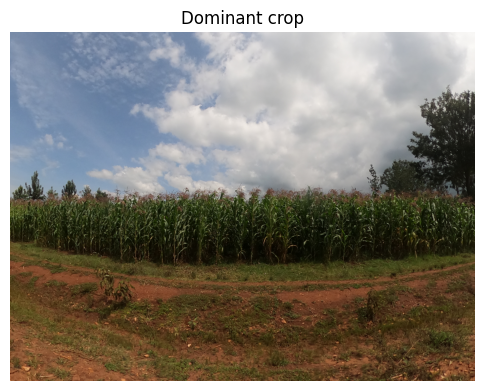

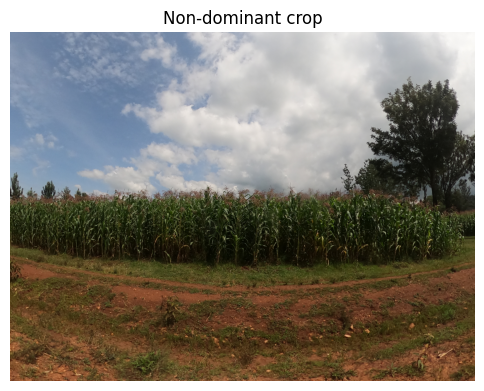

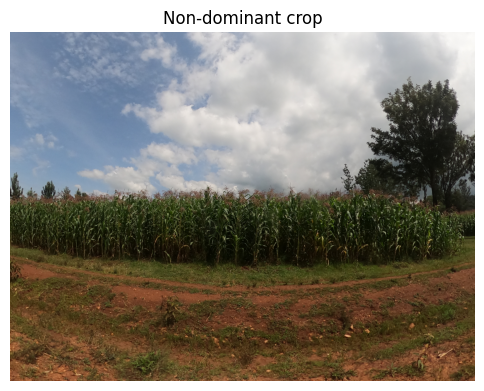

In [ ]:
gcloud_image_path_dominant = df["input_img"].iloc[2610]
gcloud_image_path = df["input_img"].iloc[2611]
gcloud_image_path_1 = df["input_img"].iloc[2612]
!gsutil cp $gcloud_image_path_dominant .
!gsutil cp $gcloud_image_path .
!gsutil cp $gcloud_image_path_1 .

from PIL import Image
import matplotlib.pyplot as plt

# Open the downloaded images
image_path_dominant = gcloud_image_path_dominant.split("/")[-1]
image_dominant = Image.open(image_path_dominant)
image_path = gcloud_image_path.split("/")[-1]
image = Image.open(image_path)
image_path_1 = gcloud_image_path.split("/")[-1]
image_1 = Image.open(image_path_1)

# Display the images
plt.figure(figsize=(6, 6))
plt.imshow(image_dominant)
plt.title('Dominant crop')
plt.axis('off')
plt.show()
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title('Non-dominant crop')
plt.axis('off')
plt.show()
plt.figure(figsize=(6, 6))
plt.imshow(image_1)
plt.title('Non-dominant crop')
plt.axis('off')
plt.show()

# **4. Download new csv file with no duplicates**

In [ ]:
# check that resulting DataFrame number of rows is same as number of groups from step 2.
result_df['road_pixel_centroid'].shape

(1489,)

In [ ]:
# download new file (RENAME BELOW)
result_df.to_csv('Kenya_ADM1_51331_Rift_Valley_ADM2_51391_Trans_Nzoia_No_Duplicates.csv')

File should appear in 'Files' tab on left
1. Click on the 3 dots
2. Click on 'Download'